In [177]:
import gtsam
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import time
import random
import math
from __future__ import print_function
from graphviz import Digraph
import graphviz
from gtsam import Rot3, Point3, Pose3
from gtsam.utils import *

In [178]:
# for Library Information
# print("Pose3", dir(Pose3))
# print("Rot3", dir(Rot3))
# print("gtsam", dir(gtsam.gtsam))
# print("KeyVector", dir(gtsam.KeyVector))
# print("GncLMOptimizer", dir(gtsam.GncLMOptimizer))
print("GncLMParams", dir(gtsam.GncLMParams))
# print("setKnownInliers", dir(gtsam.GncLMParams.setKnownInliers))
# print("setKnownOutliers", dir(gtsam.GncLMParams.setKnownOutliers))
# print("knownInliers", dir(gtsam.GncLMParams.knownInliers))

GncLMParams ['Verbosity', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'baseOptimizerParams', 'knownInliers', 'knownOutliers', 'lossType', 'maxIterations', 'muStep', 'print', 'relativeCostTol', 'setKnownInliers', 'setKnownOutliers', 'setLossType', 'setMaxIterations', 'setMuStep', 'setRelativeCostTol', 'setVerbosityGNC', 'setWeightsTol', 'verbosity', 'weightsTol']


In [179]:
def rotation_matrix_to_euler(R):
    R = np.array(R)

    # Extract individual rotation elements from the rotation matrix
    yaw = np.arctan2(R[1, 0], R[0, 0])
    pitch = np.arctan2(-R[2, 0], np.sqrt(R[2, 1] ** 2 + R[2, 2] ** 2))
    roll = np.arctan2(R[2, 1], R[2, 2])

    return yaw, pitch, roll


def Pose_to_Mat(poses):
    a = []
    for pose in poses:
        t = pose.translation()
        r = pose.rotation().matrix()
        r = np.array(r)
        # r = r.ravel()
        y, p, r = rotation_matrix_to_euler(r)
        a.append([t[0], t[1], t[2], y, p, r])
    return a


def Mat_to_Pose(poses):
    a = []
    for pose in poses:
        p = Pose3(
            Rot3.Ypr(pose[3], pose[4], pose[5]), Point3(pose[0], pose[1], pose[2])
        )
        a.append(p)
    return a

In [180]:
custom_colors = [
    "red",
    "green",
    "blue",
    "purple",
    "orange",
    "cyan",
    "magenta",
    "yellow",
    "lime",
    "teal",
]

In [181]:
def plot_arrows_6dof(points_xyz_and_angles, colors=None, flag_radians=True):
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Extract individual components from the points_xyz_and_angles
    points_xyz_and_angles = np.array(points_xyz_and_angles)
    xyz_coordinates = points_xyz_and_angles[:, :3]  # Extract XYZ coordinates
    x, y, z = xyz_coordinates[:, 0], xyz_coordinates[:, 1], xyz_coordinates[:, 2]

    # Arrow length (you can adjust this based on your needs)
    arrow_length = 30

    for i, point in enumerate(points_xyz_and_angles):
        x_i, y_i, z_i, yaw, pitch, roll = point

        if flag_radians == True:
            yaw_rad, pitch_rad, roll_rad = (
                yaw,
                pitch,
                roll,
            )
        else:
            yaw_rad, pitch_rad, roll_rad = (
                np.radians(yaw),
                np.radians(pitch),
                np.radians(roll),
            )

        # Compute the arrow components in the X, Y, and Z directions
        dx = arrow_length * np.cos(pitch_rad) * np.cos(yaw_rad)
        dy = arrow_length * np.cos(pitch_rad) * np.sin(yaw_rad)
        dz = arrow_length * np.sin(pitch_rad)

        color = colors[i] if colors is not None else "b"

        # Plot the arrow with the specified color
        ax.quiver(x_i, y_i, z_i, dx, dy, dz, color=color, arrow_length_ratio=0.2)

    # Set labels for each axis
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Adjust the plot limits (you can adjust this based on your data range)
    min_x = min(x)
    max_x = max(x)
    min_y = min(y)
    max_y = max(y)
    min_z = min(z)
    max_z = max(z)

    ax.set_xlim([min_x - arrow_length, max_x + arrow_length])
    ax.set_ylim([min_y - arrow_length, max_y + arrow_length])
    ax.set_zlim([min_z - arrow_length, max_z + arrow_length])

    plt.show()


# # Example input in the format [[x1, y1, z1, yaw1, pitch1, roll1], [x2, y2, z2, yaw2, pitch2, roll2], ...]
# points_xyz_and_angles = [
#     [100, 100, 100, 30, 45, 60],
#     [100, 400, 100, 45, 60, 90],
#     [400, 100, 100, 60, 90, 120],
#     [400, 400, 100, 90, 120, 150],
#     [250, 400, 100, 120, 150, 180],
#     [0, 0, 0, 0, 0, 0],
# ]

# Call the plot_arrows_6dof function to visualize 6-DOF points as arrows with custom colors
# plot_arrows_6dof(points_xyz_and_angles, colors=custom_colors)# Call the plot_arrows_6dof function to visualize 6-DOF points as arrows with custom colors
# plot_arrows_6dof(points_xyz_and_angles, colors=custom_colors)

In [182]:
# for Dynamic Static for 6Dof Graph Matching
# Scenes in Pose3 arrays

Scene1 = [
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 10, 10)),
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 40, 10)),
    Pose3(Rot3(), Point3(100, 0, 0)),
    Pose3(Rot3(), Point3(0, 100, 0)),
    Pose3(Rot3(), Point3(0, 100, 0)),
]

transform = Pose3(Rot3(), Point3(0, 0, 0))
deviation = Pose3(Rot3.Ypr(0, 0, math.radians(20)), Point3(0, 0, 0))

Scene2 = [
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 10, 10)),
    Pose3(Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), Point3(10, 40, 10)),
    Pose3(Rot3(), Point3(100, 0, 0)),
    Pose3(Rot3(), Point3(0, 100, 0)),
    Pose3(Rot3(), Point3(0, 100, 0)),
]

In [183]:
def transform_poses(poses, R=None, t=None, transform=None):
    if transform is not None:
        transformed_poses = []
        for pose in poses:
            # Transform the pose using T
            transformed_pose = transform * pose
            # Add the transformed pose to the list
            transformed_poses.append(transformed_pose)
        return transformed_poses

    if R is None or t is None:
        raise ValueError("Must provide either a transform or R and t")
    rot_matrix = gtsam.Rot3(R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7], R[8])
    translation = gtsam.Point3(t[0], t[1], t[2])

    # Create the transformation as a gtsam.Pose3
    T = gtsam.Pose3(rot_matrix, translation)

    # Create an empty list to store the transformed poses
    transformed_poses = []

    # Loop through each pose in the list
    for pose in poses:
        # Transform the pose using T
        transformed_pose = T * pose
        # Add the transformed pose to the list
        transformed_poses.append(transformed_pose)

    return transformed_poses


# Example usage
# poses = [gtsam.Pose3()]

# print("Poses ", poses)

# R = [-1, 0, 0, 0, 1, 0, 0, 0, -1]
# t = [0, 0, 0]

# transform_poses_val = transform_poses(poses, R, t)

# transform_poses_val = transform_poses(
#     poses, transform=gtsam.Pose3(Rot3(), Point3(10, 0, 0))
# )

# print("\ntransform poses", transform_poses_val)# print("\ntransform poses", transform_poses_val)

In [184]:
# addind noise to the data
noise = Pose3(Rot3.Ypr(0,0,0), Point3(100, 100, 100))
print(Scene2[0])
print(Scene1[0])
Scene2[0] = Scene2[0] * noise
print(Scene2[0])
print(Scene1[0])

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 10 10 10

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 10 10 10

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 110 110 110

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 10 10 10



In [185]:
R = [-1, 0, 0, 0, 1, 0, 0, 0, -1]
t = [0, 0, 0]
Scene3 = transform_poses(Scene2, R, t)
# Scene3 = transform_poses(Scene1, R, t)

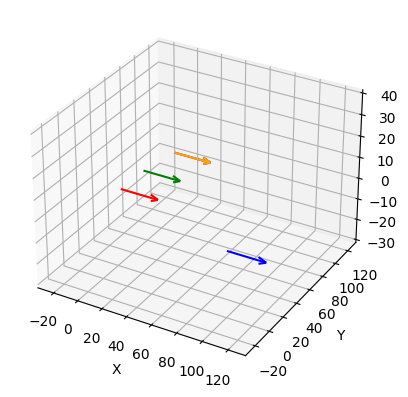

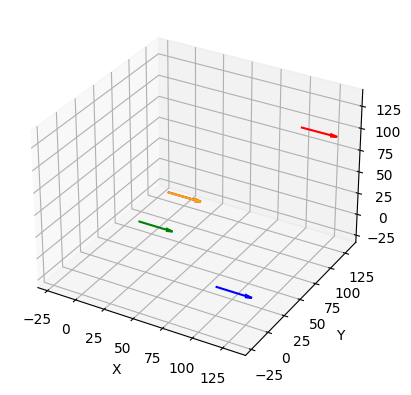

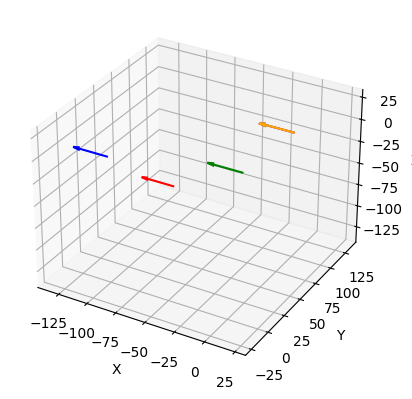

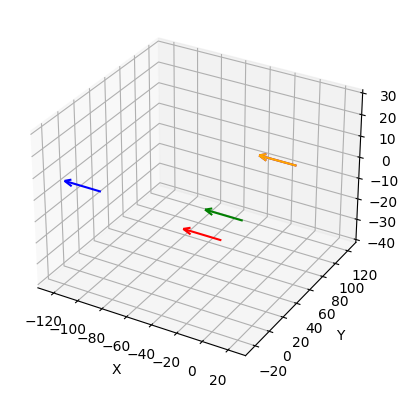

In [186]:
scene1 = Pose_to_Mat(Scene1)
scene2 = Pose_to_Mat(Scene2)
scene3 = Pose_to_Mat(Scene3)
scene4 = Pose_to_Mat(Scene4)

plot_arrows_6dof(scene1, colors=custom_colors)
plot_arrows_6dof(scene2, colors=custom_colors)
plot_arrows_6dof(scene3, colors=custom_colors)
plot_arrows_6dof(scene4, colors=custom_colors)

In [187]:
graph_6dof = gtsam.NonlinearFactorGraph()
initial_6dof = gtsam.Values()

Link1_6dof = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Link2_6dof = gtsam.noiseModel.Diagonal.Sigmas([0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
Prior_6dof = gtsam.noiseModel.Diagonal.Sigmas([0, 0, 0, 0, 0, 0])

graph_vis_6dof = Digraph(comment="Simple Directed Graph")
graph_vis_6dof = graphviz.Graph()

Poses_Ref_6dof = []
Poses_Test_6dof = []
index_6dof = []

graph_6dof.add(gtsam.PriorFactorPose3(0, Scene1[0], Prior_6dof))

index_6dof.append(0)

# creating scene graph 1
for i in range(len(Scene1)):
    for j in range(0, i + 1):
        if i == j:
            continue
        # print(f"{i}, {j}")
        index_6dof.append((i, j))
        graph_6dof.add(
            gtsam.BetweenFactorPose3(i, j, Scene1[i].between(Scene1[j]), Link1_6dof)
        )
    initial_6dof.insert(i, Scene1[i])

# create scene graph 2
for i in range(len(Scene3)):
    for j in range(0, i + 1):
        if i == j:
            continue
        # print(f"{i+ len(Scene1)}, {j + len(Scene1)}")
        index_6dof.append((i + len(Scene1), j + len(Scene1)))
        graph_6dof.add(
            gtsam.BetweenFactorPose3(
                len(Scene1) + i,
                len(Scene1) + j,
                Scene3[i].between(Scene3[j]),
                Link1_6dof,
            )
        )
    initial_6dof.insert(len(Scene1) + i, Scene3[i])

# adding data association between scene 1 and scene 2
for i in range(len(Scene1)):
    graph_6dof.add(gtsam.BetweenFactorPose3(i, i + len(Scene1), Pose3(), Link2_6dof))
    index_6dof.append((i, i + len(Scene1)))

In [188]:
# GNC LM Optimizer
LM_params_6dof = gtsam.LevenbergMarquardtParams()

gnc_lm_params_6dof = gtsam.GncLMParams(LM_params_6dof)

# inlier_6dof = gtsam.KeyVector()
# inlier_6dof.append(0)
# inlier_6dof.append(1)
# inlier_6dof.append(2)
# inlier_6dof.append(3)
# inlier_6dof.append(4)
# inlier_6dof.append(5)
# inlier_6dof.append(6)
# inlier_6dof.append(7)
# inlier_6dof.append(8)
# inlier_6dof.append(9)
# inlier_6dof.append(10)
# inlier_6dof.append(11)
# inlier_6dof.append(12)
# gnc_lm_params_6dof.setKnownInliers(inlier_6dof)

print(gnc_lm_params_6dof)

gnc_lm_optimizer_6dof = gtsam.GncLMOptimizer(
    graph_6dof, initial_6dof, gnc_lm_params_6dof
)
gnc_lm_optimizer_6dof.optimize()

# print("Weights : ", gnc_lm_optimizer.getWeights())
weights = gnc_lm_optimizer_6dof.getWeights()

print(len(weights), len(index_6dof))

graph_vis_6dof = graphviz.Graph()
for i in range(len(weights)):
    print("Edge : ", index_6dof[i], " Weigth : ", weights[i])
    print(index_6dof[i])
    if i > 0:
        k, l = index_6dof[i]
        graph_vis_6dof.edge(str(k), str(l), label=str(weights[i]))
graph_vis_6dof.render("graph_matching_6dof", view=False)

GncParams: 
lossType: Truncated Least-squares
maxIterations: 100
muStep: 1.4
relativeCostTol: 1e-05
weightsTol: 0.0001
verbosity: 0
Base optimizer params: 
relative decrease threshold: 1e-05
absolute decrease threshold: 1e-05
      total error threshold: 0
         maximum iterations: 100
                  verbosity: SILENT
         linear solver type: MULTIFRONTAL CHOLESKY
                   ordering: COLAMD
              lambdaInitial: 1e-05
               lambdaFactor: 10
           lambdaUpperBound: 100000
           lambdaLowerBound: 0
           minModelFidelity: 0.001
            diagonalDamping: 0
                minDiagonal: 1e-06
                maxDiagonal: 1e+32
                verbosityLM: SILENT

26 26
Edge :  0  Weigth :  4.893273984726366e-06
0
Edge :  (1, 0)  Weigth :  1.0
(1, 0)
Edge :  (2, 0)  Weigth :  1.0
(2, 0)
Edge :  (2, 1)  Weigth :  1.0
(2, 1)
Edge :  (3, 0)  Weigth :  1.0
(3, 0)
Edge :  (3, 1)  Weigth :  1.0
(3, 1)
Edge :  (3, 2)  Weigth :  1.0
(3, 2)
Edge : 

'graph_matching_6dof.pdf'